# Appendix A:  Calculating the FDR threshold

This Appendix demonstrates how to calculate false discovery rate (FDR) thresholds for 1D data analysis using the procedure of Benjamini & Hochberg (1995). A one-sample test will be used for simplicity, but the identical procedures can be applied to any test.

Let's start by importing the Python packages we'll need to run subsequent analyses.

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot
import spm1d

Next let's generate a smooth, random 1D dataset.

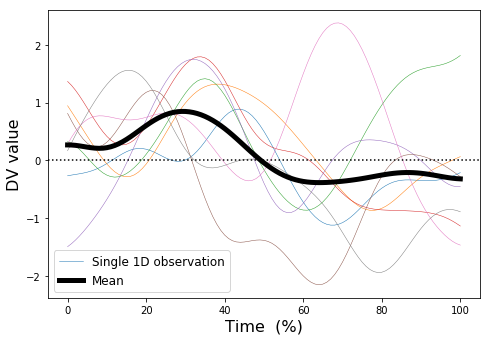

In [2]:
# Generate random data:
np.random.seed(246)
J    = 8
Q    = 101
FWHM = 20
y    = spm1d.rft1d.randn1d(J, Q, FWHM, pad=True)


# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
h0   = ax.plot(y.T, linewidth=0.5)[0]
h1   = ax.plot(y.mean(axis=0), linewidth=5, color='k')[0]
ax.axhline(0, color='k', linestyle=':')
ax.legend([h0,h1], ['Single 1D observation', 'Mean'], fontsize=12)
ax.set_xlabel('Time  (%)', size=16)
ax.set_ylabel('DV value', size=16);
pyplot.show()

The goal is to test the null hypothesis that the true population mean is zero:

$$H_0: \overline{y}(q) = 0 \ \ \ \ \textrm{for all} \ \ q$$

where $\overline{y}(q)$ is the mean value at time point $q$, and where $q$ lies in the range 0 to 100%.

___

### Step 1:  Calculate test statistic continuum

The one-sample t statistic is defined as:

$$t(q) = \frac{\overline{y}(q)}{s(q)\big/\sqrt{J}}$$

where $t$ is the t statistic, $q$ is the 1D continuum position, $s$ is the sample standard deviation, and $J$ is the sample size.

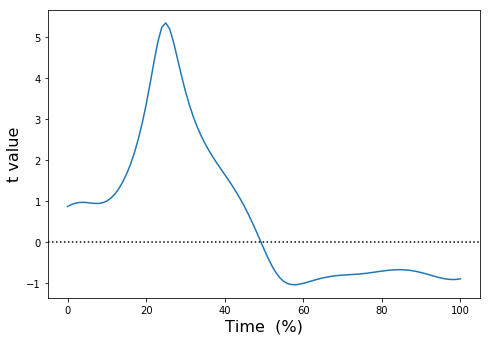

In [3]:
# Compute test statistic:
t = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )

# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
ax.plot(t)
ax.axhline(0, color='k', linestyle=':')
ax.set_xlabel('Time  (%)', size=16)
ax.set_ylabel('t value', size=16);
pyplot.show()

___

### Step 2:  Calculate uncorrected P value continuum

Uncorrected P values can be computed using the Student's t distribution as indicated below.  Note that large t values correspond to small p values.

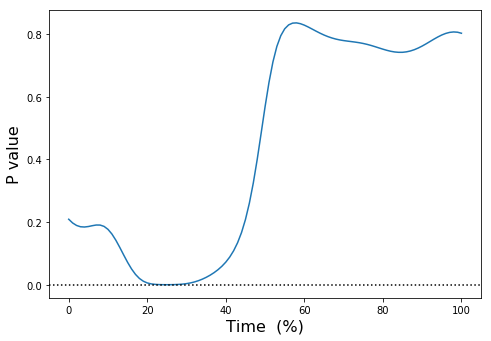

In [4]:
# Compute uncorrected p values:
df   = J - 1
p    = scipy.stats.t.sf(t, df)

# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
ax.plot(p)
ax.axhline(0, color='k', linestyle=':')
ax.set_xlabel('Time  (%)', size=16)
ax.set_ylabel('P value', size=16);
pyplot.show()

___

### Step 3:  Sort P values

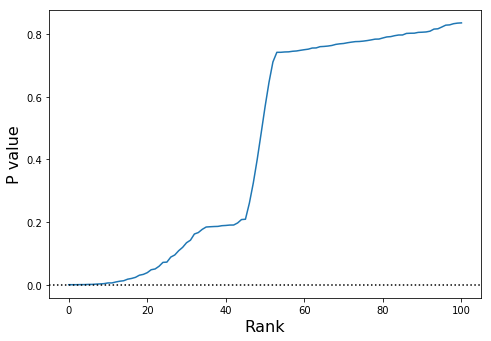

In [5]:
psorted = np.sort(p)

# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
ax.plot(psorted)
ax.axhline(0, color='k', linestyle=':')
ax.set_xlabel('Rank', size=16)
ax.set_ylabel('P value', size=16);
pyplot.show()

___

### Step 4:  Calculate the theoretical signal-dependent threshold  

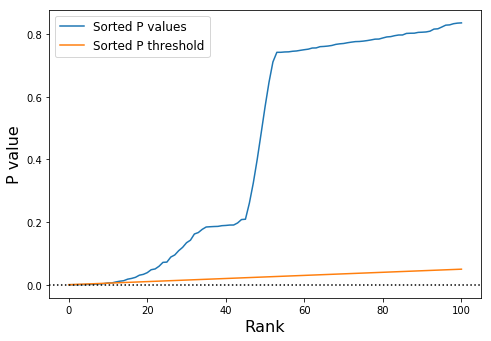

In [6]:
alpha     = 0.05
slope     = alpha / Q
ind       = np.arange(Q) + 1
psortedth = slope * ind       #sorted p threshold


# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
ax.plot(psorted, label='Sorted P values')
ax.plot(psortedth, label='Sorted P threshold')
ax.axhline(0, color='k', linestyle=':')
ax.set_xlabel('Rank', size=16)
ax.set_ylabel('P value', size=16)
ax.legend(fontsize=12);
pyplot.show()

Zooming in shows where the P values cross the threshold:

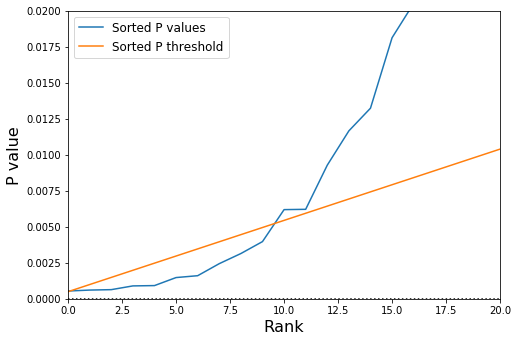

In [7]:
# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
ax.plot(psorted, label='Sorted P values')
ax.plot(psortedth, label='Sorted P threshold')
ax.axhline(0, color='k', linestyle=':')
ax.set_xlabel('Rank', size=16)
ax.set_ylabel('P value', size=16)
ax.legend(fontsize=12);
ax.set_xlim([0,20])
ax.set_ylim([0,0.02])
pyplot.show()

___

### Step 5:  Calculate P threshold

The P threshold is the largest P value that is less than the FDR threshold. From the figure above it is clear that the P threshold is approximately 0.005.  This can be extracted algorithmically as follows:

In [8]:
ind   = np.argwhere( psorted < psortedth ).flatten()[-1]
pstar = psorted[ind]
print('P threshold = %.5f'%pstar)

P threshold = 0.00397


___

### Step 6:  Calculate test statistic threshold

In [9]:
i        = np.argsort(p)
tsorted  = t[i]
tstarFDR = tsorted[ind]
print('t threshold (FDR) = %.3f'%tstarFDR)

t threshold (FDR) = 3.672


Now we can check the results in the context of the 1D test statistic:

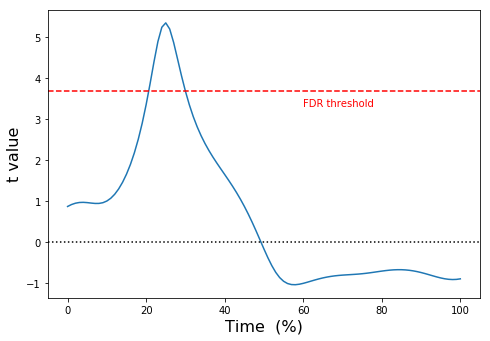

In [10]:
# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
ax.plot(t)
ax.axhline(0, color='k', linestyle=':')
ax.axhline(tstarFDR, color='r', linestyle='--')
ax.text(60, 3.3, 'FDR threshold', color='r')
ax.set_xlabel('Time  (%)', size=16)
ax.set_ylabel('t value', size=16);
pyplot.show()

How does this compare to normal SPM results? SPM's one-sample analyses can be run using **spm1d.stats.ttest** as indicated below.

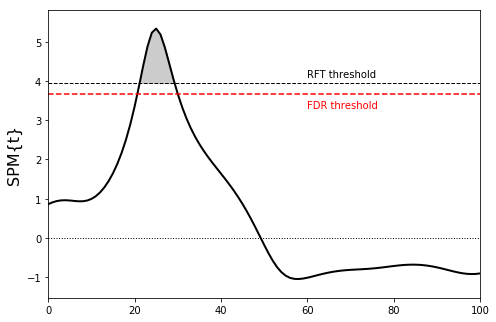

In [11]:
# SPM analysis:
spm  = spm1d.stats.ttest(y)
spmi = spm.inference(0.05, two_tailed=False)


# Plot:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
spmi.plot()
ax.text(60, 4.1, 'RFT threshold', color='k')
ax.axhline(tstarFDR, color='r', linestyle='--')
ax.text(60, 3.3, 'FDR threshold', color='r');
pyplot.show()

From the figure above we can see that SPM's default random field theory (RFT) results is qualitatively similar to the FDR results, but also that the RFT threshold is slightly higher than the FDR threshold. The implications of these different thresholds, as well as their interpretations, are explored in the subsequent Appendix material.

___

### A function for conducting FDR inference:

The function below replicates the above analyses. A more general function, applicable to arbitrary statistics and experimental designs, is available in the **fdr1d** package ( https://github.com/0todd0000/fdr1d ).

In [12]:
def fdr_inference(t, df, alpha=0.05):
    p         = scipy.stats.t.sf(t, df)  #uncorrected p values
    i         = np.argsort(p)            #indices of sorted p values
    psorted   = p[i]                     #sorted p values
    Q         = t.size                   #number of continuum nodes
    psortedth = alpha / Q * (np.arange(Q) + 1)  #sorted p value threshold
    b         = psorted < psortedth      
   
    if np.any(b):
        istar = np.argwhere(b).flatten()[-1] #last sorted index less than the threshold
        tstar = t[i][istar]                  #test statistic threshold
    else:
        tstar = None
    
    return tstar

Let's last verify that this function returns the same threshold:

In [13]:
tstar   = fdr_inference(t, J-1, alpha=0.05)
print('t threshold = %.3f'%tstar)

t threshold = 3.672


### References

Benjamini Y, Hochberg Y (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. J Royal Statist Soc B 57(1):289-300.